The purpose of this project is to use data on United States vaccination rates, population, and travel statistics to predict locations within the US that will be safe to travel to in the near future.

In [146]:
import numpy as np
import pandas as pd
import csv
import requests
import io
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import plotly.graph_objects as go

The first dataset we will be using was accessed at: https://www.kaggle.com/bumjunkoo/us-vaccination-progress 
This dataset goes back to 1/12/21 and we sourced it on 7/6/21. This gave us nearly 6 months of data on vaccination statistics in the US. Initially we are building an example model with just one day's worth of data.

In [35]:
#Loading the initial state vaccination csv.
data = pd.read_csv('us_state_vaccinations.csv')
data['date'] = data['date'].astype('datetime64[ns]')
data['state'] = data['location']
data['vaxxed_per_hundred'] = data['people_fully_vaccinated_per_hundred']

display(data.isnull().sum())
safe = data[data['vaxxed_per_hundred'] > 45]
print(safe.shape)
#Extrapolating the needed data into a new dataframe.
cut = data.drop(columns = ['total_distributed', 'people_fully_vaccinated_per_hundred','location','people_vaccinated', 
                           'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'distributed_per_hundred'
                           , 'daily_vaccinations_raw', 'daily_vaccinations_per_million', 'share_doses_used'])

new = cut.loc[(cut['date'] == '2021-07-06')]
new = new.replace({"state": "New York State"}, "New York")
print(new.head(55))

us = cut.loc[(cut['state'] == 'United States')]
us['vaxxed_per_hundred'] = us['vaxxed_per_hundred'].interpolate(method='linear', limit_direction='forward')

date                                      0
location                                  0
total_vaccinations                      400
total_distributed                       580
people_vaccinated                       592
people_fully_vaccinated_per_hundred    1214
total_vaccinations_per_hundred         1112
people_fully_vaccinated                 674
people_vaccinated_per_hundred          1137
distributed_per_hundred                1125
daily_vaccinations_raw                   65
daily_vaccinations                       65
daily_vaccinations_per_million          800
share_doses_used                        580
state                                     0
vaxxed_per_hundred                     1214
dtype: int64

(1100, 16)
           date  total_vaccinations  people_fully_vaccinated  \
175  2021-07-06           3392366.0                1617584.0   
351  2021-07-06            678029.0                 322988.0   
527  2021-07-06             47310.0                  21583.0   
703  2021-07-06           6826215.0                3172380.0   
879  2021-07-06           2261649.0                1043217.0   
1055 2021-07-06            195652.0                  96792.0   
1231 2021-07-06          43182509.0               19949682.0   
1407 2021-07-06           6245280.0                3018088.0   
1583 2021-07-06           4443865.0                2184079.0   
1759 2021-07-06           1050376.0                 493459.0   
1935 2021-07-06           4341321.0                1864193.0   
2111 2021-07-06            873977.0                 373883.0   
2287 2021-07-06             51612.0                  26130.0   
2463 2021-07-06          21329822.0                9983279.0   
2639 2021-07-06           851

<ipython-input-35-933ecd4a0f78>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us['vaxxed_per_hundred'] = us['vaxxed_per_hundred'].interpolate(method='linear', limit_direction='forward')


The figure below shows the steady increase of vaccinations within the US over the past 6 months.

Text(0.5, 1.0, 'US Vaccinations')

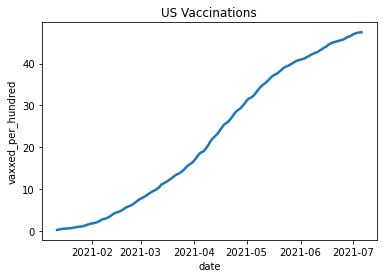

In [36]:
# Visualizing US vaccinations
f, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=us, x = 'date', y = 'vaxxed_per_hundred', palette="tab10", linewidth=2.5)
plt.title('US Vaccinations')

The next dataset we sourced from the New York Times GitHub at: https://github.com/nytimes/covid-19-data
This dataset is regularly updated and dates back to 1/21/2020, the very beginning of the pandemic in the United States. We decided to make use of the rolling average dataset for states in the US.

In [37]:
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-states.csv" 
download = requests.get(url).content

#Creating a new dataframe for rolling average values

rolling_avg = pd.read_csv(io.StringIO(download.decode('utf-8')))

rolling_avg['date'] = pd.to_datetime(rolling_avg['date'], format='%Y-%m-%d')

#Extrapolating needed data into a new rolling average dataframe.
rolling_avg = rolling_avg.drop(columns = ['geoid', 'cases', 'deaths', 'deaths_avg_per_100k'])

raNew = rolling_avg.loc[(rolling_avg['date'] =='2021-07-06')]
raNew.head(55)

date                     state  cases_avg  cases_avg_per_100k  \
26964 2021-07-06  Northern Mariana Islands       0.00                0.00   
26965 2021-07-06                      Guam       6.57                3.90   
26966 2021-07-06               Puerto Rico      55.00                1.62   
26967 2021-07-06            Virgin Islands      12.00               11.30   
26968 2021-07-06                   Wyoming      63.86               11.03   
26969 2021-07-06                 Wisconsin      73.86                1.27   
26970 2021-07-06             West Virginia      41.00                2.29   
26971 2021-07-06                Washington     331.86                4.36   
26972 2021-07-06                  Virginia     180.14                2.11   
26973 2021-07-06                   Vermont       3.86                0.62   
26974 2021-07-06                      Utah     384.86               12.00   
26975 2021-07-06                     Texas    1332.86                4.60   
26976 2021-07-06                 Tennessee     190.57                2.79   
26977 2021-07-06              South Dakota       8.71                0.99   
26978 2021-07-06            South Carolina     197.29                3.83   
26979 2021-07-06              Rhode Island      15.57                1.47   
26980 2021-07-06              Pennsylvania     162.43                1.27   
26981 2021-07-06                    Oregon     151.00                3.58   
26982 2021-07-06                  Oklahoma     278.43                7.04   
26983 2021-07-06                      Ohio     223.57                1.91   
26984 2021-07-06              North Dakota      10.14                1.33   
26985 2021-07-06            North Carolina     338.00                3.22   
26986 2021-07-06                  New York     345.71                1.78   
26987 2021-07-06                New Mexico      61.57                2.94   
26988 2021-07-06                New Jersey     180.71                2.03   
26989 2021-07-06             New Hampshire      20.71                1.52   
26990 2021-07-06                    Nevada     422.14               13.71   
26991 2021-07-06                  Nebraska      35.43                1.83   
26992 2021-07-06                   Montana      37.43                3.50   
26993 2021-07-06                  Missouri     991.29               16.15   
26994 2021-07-06               Mississippi     203.86                6.85   
26995 2021-07-06                 Minnesota      72.29                1.28   
26996 2021-07-06                  Michigan     170.43                1.71   
26997 2021-07-06             Massachusetts      79.29                1.15   
26998 2021-07-06                  Maryland      66.29                1.10   
26999 2021-07-06                     Maine      13.86                1.03   
27000 2021-07-06                 Louisiana     528.71               11.37   
27001 2021-07-06                  Kentucky     147.43                3.30   
27002 2021-07-06                    Kansas     130.00                4.46   
27003 2021-07-06                      Iowa      78.57                2.49   
27004 2021-07-06                   Indiana     311.29                4.62   
27005 2021-07-06                  Illinois     326.14                2.57   
27006 2021-07-06                     Idaho      75.57                4.23   
27007 2021-07-06                    Hawaii      48.00                3.39   
27008 2021-07-06                   Georgia     474.71                4.45   
27009 2021-07-06                   Florida    1492.57                6.95   
27010 2021-07-06      District of Columbia      13.67                1.94   
27011 2021-07-06                  Delaware      26.86                2.76   
27012 2021-07-06               Connecticut      50.00                1.40   
27013 2021-07-06                  Colorado     380.00                6.60   
27014 2021-07-06                California    1504.40                3.81   
27015 20

The following figure illustrates the surge and decline of Covid-19 cases in the United States over the past 18 months.

<AxesSubplot:title={'center':'US Covid Cases'}, xlabel='date'>

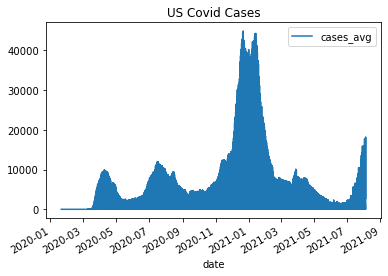

In [38]:
rolling_avg.plot.line(x = 'date', y = 'cases_avg', title= 'US Covid Cases')

The third source of data was accessed from the Johns Hopkins GitHub at: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
The repository is updated daily and goes back to 1/1/2021. This was where we expected to source much of our data. Unfortunately, attributes such as "Recovered" and "Active" were not reported in more recent updates.

In [39]:
url_2 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/07-05-2021.csv"
dl = requests.get(url_2).content

#Loading the initial dataframe for the master covid data
jH = pd.read_csv(io.StringIO(dl.decode('utf-8')))

jH['state'] = jH['Province_State']

#Extrapolating the needed data into a new dataframe
jHnew = jH.drop(columns = ['Last_Update','Province_State','Country_Region','Lat', 'Long_', 'FIPS', 'Total_Test_Results', 'People_Hospitalized', 'UID', 'ISO3', 
                           'Testing_Rate', 'Hospitalization_Rate'])

jHnew.head()

Confirmed  Deaths  Recovered  Active  Incident_Rate  Case_Fatality_Ratio  \
0     551298   11358        NaN     NaN   11243.671206             2.060229   
1      71384     377        NaN     NaN    9757.977978             0.528130   
2          0       0        NaN     NaN       0.000000                  NaN   
3     897010   17979        NaN     NaN   12323.737824             2.004325   
4     351825    5920        NaN     NaN   11658.311806             1.682655   

            state  
0         Alabama  
1          Alaska  
2  American Samoa  
3         Arizona  
4        Arkansas

In the following cell, we bring together our three initial datasets.

In [40]:
#Merging 2 Dataframes together
dos = pd.merge(new, raNew, on=['state','date'])
dos
dos['date'] = pd.to_datetime(dos['date'], format='%Y-%m-%d')
#Merging the Created dataframe and the master data together
all3 = pd.merge(dos, jHnew, on='state')

all3 = all3[['date', 'state', 'vaxxed_per_hundred', 'people_fully_vaccinated', 'Confirmed','cases_avg', 'deaths_avg','Deaths', 'Recovered', 
            'Active', 'Incident_Rate', 'Case_Fatality_Ratio', 'daily_vaccinations','total_vaccinations']]

#doing the math for recovered
all3['Recovered'] = all3['Confirmed'] - all3['Deaths']

#Displaying the new merged dataframe
all3.head(55)

date                     state  vaxxed_per_hundred  \
0  2021-07-06                   Alabama               32.99   
1  2021-07-06                    Alaska               44.15   
2  2021-07-06                   Arizona               43.58   
3  2021-07-06                  Arkansas               34.57   
4  2021-07-06                California               50.49   
5  2021-07-06                  Colorado               52.41   
6  2021-07-06               Connecticut               61.26   
7  2021-07-06                  Delaware               50.68   
8  2021-07-06      District of Columbia               52.98   
9  2021-07-06                   Florida               46.48   
10 2021-07-06                   Georgia               36.98   
11 2021-07-06                      Guam               55.50   
12 2021-07-06                    Hawaii               52.21   
13 2021-07-06                     Idaho               36.37   
14 2021-07-06                  Illinois               46.74   
15 2021-07-06                   Indiana               42.71   
16 2021-07-06                      Iowa               48.39   
17 2021-07-06                    Kansas               42.33   
18 2021-07-06                  Kentucky               43.97   
19 2021-07-06                 Louisiana               35.44   
20 2021-07-06                     Maine               61.94   
21 2021-07-06                  Maryland               56.62   
22 2021-07-06             Massachusetts               62.21   
23 2021-07-06                  Michigan               47.35   
24 2021-07-06                 Minnesota               52.32   
25 2021-07-06               Mississippi               29.89   
26 2021-07-06                  Missouri               39.43   
27 2021-07-06                   Montana               43.21   
28 2021-07-06                  Nebraska               48.01   
29 2021-07-06                    Nevada               42.50   
30 2021-07-06             New Hampshire               56.74   
31 2021-07-06                New Jersey               55.79   
32 2021-07-06                New Mexico               55.20   
33 2021-07-06                  New York               54.73   
34 2021-07-06            North Carolina               42.18   
35 2021-07-06              North Dakota               39.12   
36 2021-07-06  Northern Mariana Islands               47.56   
37 2021-07-06                      Ohio               45.18   
38 2021-07-06                  Oklahoma               38.77   
39 2021-07-06                    Oregon               54.29   
40 2021-07-06              Pennsylvania               50.21   
41 2021-07-06               Puerto Rico               56.40   
42 2021-07-06              Rhode Island               59.44   
43 2021-07-06            South Carolina               39.13   
44 2021-07-06              South Dakota               45.65   
45 2021-07-06                 Tennessee               37.67   
46 2021-07-06                     Texas               41.70   
47 2021-07-06                      Utah               37.48   
48 2021-07-06                   Vermont               66.10   
49 2021-07-06            Virgin Islands               33.77   
50 2021-07-06                  Virginia               52.47   
51 2021-07-06                Washington               55.24   
52 2021-07-06             West Virginia               37.47   
53 2021-07-06                 Wisconsin               50.34   
54 2021-07-06                   Wyoming               35.36   

    people_fully_vaccinated  Confirmed  cases_avg  deaths_avg  Deaths  \
0                 1617584.0     551298     121.00        2.86   11358   
1                  322988.0      71384      27.57        0.43     377   
2                 3172380.0     897010     543.43       10.00   17979   
3                 1043217.0     351825     485.14        3.00    5920   
4                19949682.0    3821572    1504.40       32.20   63655   
5                 3018088.0     559704    

In order to have a source of input for active Covid cases, we again used the New York Times GitHub repository. This gave us data on confirmed active Covid cases for each state. This data goes back to 1/22/2020.

In [41]:
url_3 = "https://raw.githubusercontent.com/datasets/covid-19/main/data/us_confirmed.csv"
dl3 = requests.get(url_3).content

#adding data from a 3rd dataframe for confirmed active covid cases by state

confirmed = pd.read_csv(io.StringIO(dl3.decode('utf-8')),  error_bad_lines=False)

C:\Users\CaseyLewis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
#Configuring the dataframe, dropping unnecessary or redundant values/changing column names to match.

confirmed['Date'] = pd.to_datetime(confirmed['Date'], format='%Y-%m-%d')
confirmed['date'] = confirmed['Date']
confirmed['state'] = confirmed['Province/State']
confirmed['Active'] = confirmed['Case']
confirmed.drop(columns=['Admin2', 'Date', 'Province/State', 'Country/Region', 'Case'], inplace=True)
display(confirmed.head())

date    state  Active
0 2020-01-22  Alabama       0
1 2020-01-23  Alabama       0
2 2020-01-24  Alabama       0
3 2020-01-25  Alabama       0
4 2020-01-26  Alabama       0

The following figure shows Covid cases over the past 18 months.

Text(0.5, 1.0, 'US Covid Cases')

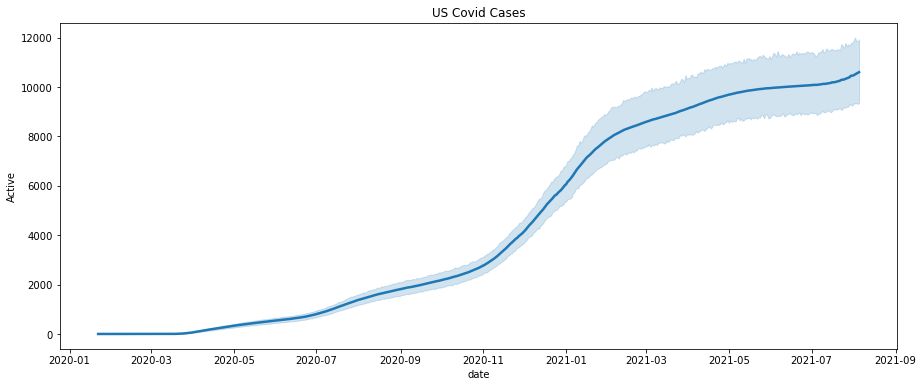

In [43]:
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=confirmed, x = 'date', y = 'Active', palette="tab10", linewidth=2.5)
plt.title('US Covid Cases')

In [44]:
#retrieving active cases from the confirmed dataframe from the 6th, to be used for an example.

result = confirmed[confirmed['date'] == '2021-07-06']

#retreiving the highest active instances for the day, grouped by state.
result = result.loc[result.groupby('state')['Active'].idxmax(), :].reset_index()
result = result.drop(columns=['index'])
result.head(55)

date                     state   Active
0  2021-07-06                   Alabama    81328
1  2021-07-06                    Alaska    31286
2  2021-07-06            American Samoa        0
3  2021-07-06                   Arizona   562308
4  2021-07-06                  Arkansas    41703
5  2021-07-06                California  1253106
6  2021-07-06                  Colorado    74519
7  2021-07-06               Connecticut   100573
8  2021-07-06                  Delaware    65138
9  2021-07-06          Diamond Princess       49
10 2021-07-06      District of Columbia    49417
11 2021-07-06                   Florida   511394
12 2021-07-06                   Georgia   103476
13 2021-07-06            Grand Princess      103
14 2021-07-06                      Guam     8394
15 2021-07-06                    Hawaii    28079
16 2021-07-06                     Idaho    53729
17 2021-07-06                  Illinois   557498
18 2021-07-06                   Indiana   103723
19 2021-07-06                      Iowa    58389
20 2021-07-06                    Kansas    59976
21 2021-07-06                  Kentucky    83251
22 2021-07-06                 Louisiana    47816
23 2021-07-06                     Maine    17270
24 2021-07-06                  Maryland    85608
25 2021-07-06             Massachusetts   135478
26 2021-07-06                  Michigan   166192
27 2021-07-06                 Minnesota   125311
28 2021-07-06               Mississippi    22438
29 2021-07-06                  Missouri   102337
30 2021-07-06                   Montana    18110
31 2021-07-06                  Nebraska    71755
32 2021-07-06                    Nevada   262134
33 2021-07-06             New Hampshire    36440
34 2021-07-06                New Jersey   105108
35 2021-07-06                New Mexico    59212
36 2021-07-06                  New York   281665
37 2021-07-06            North Carolina   114907
38 2021-07-06              North Dakota    24793
39 2021-07-06  Northern Mariana Islands      183
40 2021-07-06                      Ohio   129289
41 2021-07-06                  Oklahoma    87823
42 2021-07-06                    Oregon    40684
43 2021-07-06              Pennsylvania   154800
44 2021-07-06               Puerto Rico    18523
45 2021-07-06              Rhode Island    99519
46 2021-07-06            South Carolina    75715
47 2021-07-06              South Dakota    31764
48 2021-07-06                 Tennessee    99072
49 2021-07-06                     Texas   403646
50 2021-07-06                      Utah   154406
51 2021-07-06                   Vermont     7549
52 2021-07-06            Virgin Islands     3895
53 2021-07-06                  Virginia    77200
54 2021-07-06                Washington   112963

In [45]:
#Mapping the highest active value by state to the values of the all3['state'] column based on like data.
all3['Active'] = all3.state.map(dict(zip(result.state, result.Active)))
all3.head(55)

date                     state  vaxxed_per_hundred  \
0  2021-07-06                   Alabama               32.99   
1  2021-07-06                    Alaska               44.15   
2  2021-07-06                   Arizona               43.58   
3  2021-07-06                  Arkansas               34.57   
4  2021-07-06                California               50.49   
5  2021-07-06                  Colorado               52.41   
6  2021-07-06               Connecticut               61.26   
7  2021-07-06                  Delaware               50.68   
8  2021-07-06      District of Columbia               52.98   
9  2021-07-06                   Florida               46.48   
10 2021-07-06                   Georgia               36.98   
11 2021-07-06                      Guam               55.50   
12 2021-07-06                    Hawaii               52.21   
13 2021-07-06                     Idaho               36.37   
14 2021-07-06                  Illinois               46.74   
15 2021-07-06                   Indiana               42.71   
16 2021-07-06                      Iowa               48.39   
17 2021-07-06                    Kansas               42.33   
18 2021-07-06                  Kentucky               43.97   
19 2021-07-06                 Louisiana               35.44   
20 2021-07-06                     Maine               61.94   
21 2021-07-06                  Maryland               56.62   
22 2021-07-06             Massachusetts               62.21   
23 2021-07-06                  Michigan               47.35   
24 2021-07-06                 Minnesota               52.32   
25 2021-07-06               Mississippi               29.89   
26 2021-07-06                  Missouri               39.43   
27 2021-07-06                   Montana               43.21   
28 2021-07-06                  Nebraska               48.01   
29 2021-07-06                    Nevada               42.50   
30 2021-07-06             New Hampshire               56.74   
31 2021-07-06                New Jersey               55.79   
32 2021-07-06                New Mexico               55.20   
33 2021-07-06                  New York               54.73   
34 2021-07-06            North Carolina               42.18   
35 2021-07-06              North Dakota               39.12   
36 2021-07-06  Northern Mariana Islands               47.56   
37 2021-07-06                      Ohio               45.18   
38 2021-07-06                  Oklahoma               38.77   
39 2021-07-06                    Oregon               54.29   
40 2021-07-06              Pennsylvania               50.21   
41 2021-07-06               Puerto Rico               56.40   
42 2021-07-06              Rhode Island               59.44   
43 2021-07-06            South Carolina               39.13   
44 2021-07-06              South Dakota               45.65   
45 2021-07-06                 Tennessee               37.67   
46 2021-07-06                     Texas               41.70   
47 2021-07-06                      Utah               37.48   
48 2021-07-06                   Vermont               66.10   
49 2021-07-06            Virgin Islands               33.77   
50 2021-07-06                  Virginia               52.47   
51 2021-07-06                Washington               55.24   
52 2021-07-06             West Virginia               37.47   
53 2021-07-06                 Wisconsin               50.34   
54 2021-07-06                   Wyoming               35.36   

    people_fully_vaccinated  Confirmed  cases_avg  deaths_avg  Deaths  \
0                 1617584.0     551298     121.00        2.86   11358   
1                  322988.0      71384      27.57        0.43     377   
2                 3172380.0     897010     543.43       10.00   17979   
3                 1043217.0     351825     485.14        3.00    5920   
4                19949682.0    3821572    1504.40       32.20   63655   
5                 3018088.0     559704    

In order to calculate percentages of the states' populations which are vaccinated, we accessed United States Census Bureau data at: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html#par_textimage_1873399417
This gave us a good estimate for population to work with.

In [46]:
#Adding an additional datasource for population estimation, will be used to determine the %of the pop infected 
#as well as the % of the pop vaccinated
state_df = pd.read_csv('Population_of_US.csv', delimiter=',')
m1 = state_df['POPESTIMATE2019']
m2 = state_df['NAME']
state_df = pd.DataFrame({'state' : m2, 'population_est' : m1}, index=np.arange(len(m1)))
state_df = state_df.replace({"state": "New York State"}, "New York")
state_df.head(55)

state  population_est
0                Alabama         4903185
1                 Alaska          731545
2                Arizona         7278717
3               Arkansas         3017804
4             California        39512223
5               Colorado         5758736
6            Connecticut         3565287
7               Delaware          973764
8   District of Columbia          705749
9                Florida        21477737
10               Georgia        10617423
11                Hawaii         1415872
12                 Idaho         1787065
13              Illinois        12671821
14               Indiana         6732219
15                  Iowa         3155070
16                Kansas         2913314
17              Kentucky         4467673
18             Louisiana         4648794
19                 Maine         1344212
20              Maryland         6045680
21         Massachusetts         6892503
22              Michigan         9986857
23             Minnesota         5639632
24           Mississippi         2976149
25              Missouri         6137428
26               Montana         1068778
27              Nebraska         1934408
28                Nevada         3080156
29         New Hampshire         1359711
30            New Jersey         8882190
31            New Mexico         2096829
32              New York        19453561
33        North Carolina        10488084
34          North Dakota          762062
35                  Ohio        11689100
36              Oklahoma         3956971
37                Oregon         4217737
38          Pennsylvania        12801989
39          Rhode Island         1059361
40        South Carolina         5148714
41          South Dakota          884659
42             Tennessee         6829174
43                 Texas        28995881
44                  Utah         3205958
45               Vermont          623989
46              Virginia         8535519
47            Washington         7614893
48         West Virginia         1792147
49             Wisconsin         5822434
50               Wyoming          578759

We calculated the percentage of each state's population which is vaccinated and the percentage which may be infected on a given date.

In [47]:
all3['total_state_pop'] = all3.state.map(dict(zip(state_df.state, state_df.population_est)))
all3.dropna(inplace=True)
all3['%_pop_vaxxed'] = round((all3['people_fully_vaccinated'] / all3['total_state_pop']) *100, 2)
all3['%_pop_infected'] = round((all3['Active'] / all3['total_state_pop']) *100, 2)
#outputting an example training dataframe displaying one day's data
all3.head(55)

date                 state  vaxxed_per_hundred  \
0  2021-07-06               Alabama               32.99   
1  2021-07-06                Alaska               44.15   
2  2021-07-06               Arizona               43.58   
3  2021-07-06              Arkansas               34.57   
4  2021-07-06            California               50.49   
5  2021-07-06              Colorado               52.41   
6  2021-07-06           Connecticut               61.26   
7  2021-07-06              Delaware               50.68   
8  2021-07-06  District of Columbia               52.98   
9  2021-07-06               Florida               46.48   
10 2021-07-06               Georgia               36.98   
12 2021-07-06                Hawaii               52.21   
13 2021-07-06                 Idaho               36.37   
14 2021-07-06              Illinois               46.74   
15 2021-07-06               Indiana               42.71   
16 2021-07-06                  Iowa               48.39   
17 2021-07-06                Kansas               42.33   
18 2021-07-06              Kentucky               43.97   
19 2021-07-06             Louisiana               35.44   
20 2021-07-06                 Maine               61.94   
21 2021-07-06              Maryland               56.62   
22 2021-07-06         Massachusetts               62.21   
23 2021-07-06              Michigan               47.35   
24 2021-07-06             Minnesota               52.32   
25 2021-07-06           Mississippi               29.89   
26 2021-07-06              Missouri               39.43   
27 2021-07-06               Montana               43.21   
28 2021-07-06              Nebraska               48.01   
29 2021-07-06                Nevada               42.50   
30 2021-07-06         New Hampshire               56.74   
31 2021-07-06            New Jersey               55.79   
32 2021-07-06            New Mexico               55.20   
33 2021-07-06              New York               54.73   
34 2021-07-06        North Carolina               42.18   
35 2021-07-06          North Dakota               39.12   
37 2021-07-06                  Ohio               45.18   
38 2021-07-06              Oklahoma               38.77   
39 2021-07-06                Oregon               54.29   
40 2021-07-06          Pennsylvania               50.21   
42 2021-07-06          Rhode Island               59.44   
43 2021-07-06        South Carolina               39.13   
44 2021-07-06          South Dakota               45.65   
45 2021-07-06             Tennessee               37.67   
46 2021-07-06                 Texas               41.70   
47 2021-07-06                  Utah               37.48   
48 2021-07-06               Vermont               66.10   
50 2021-07-06              Virginia               52.47   
51 2021-07-06            Washington               55.24   
52 2021-07-06         West Virginia               37.47   
53 2021-07-06             Wisconsin               50.34   
54 2021-07-06               Wyoming               35.36   

    people_fully_vaccinated  Confirmed  cases_avg  deaths_avg  Deaths  \
0                 1617584.0     551298     121.00        2.86   11358   
1                  322988.0      71384      27.57        0.43     377   
2                 3172380.0     897010     543.43       10.00   17979   
3                 1043217.0     351825     485.14        3.00    5920   
4                19949682.0    3821572    1504.40       32.20   63655   
5                 3018088.0     559704     380.00        4.43    6817   
6                 2184079.0     349476      50.00        0.43    8279   
7                  493459.0     109891      26.86        0.14    1695   
8                  373883.0      49378      13.67        0.00    1141   
9                 9983279.0    2381148    1492.57       21.29   37985   
10                3926832.0    1135526     474.71        8.43   21443   
12                 739265.0      38043      48.00        0.29   

The following figure shows the percentage of the population of each state which was vaccinated as of 7/6/2021.

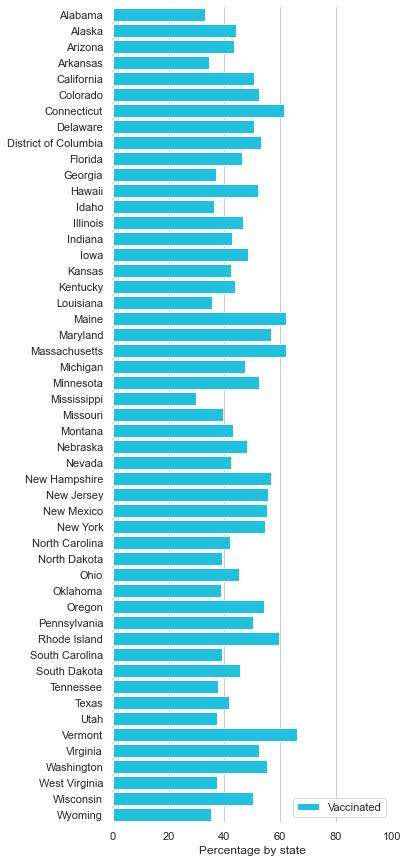

In [48]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(5, 15))


sns.set_color_codes("bright")
sns.barplot(x="%_pop_vaxxed", y="state", data=all3,
            label="Vaccinated", color="c")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Percentage by state")
sns.despine(left=True, bottom=True)

We have our examples based on a day's worth of data, now we will build our working model using 6 months of data from our sources. Some of our sources consist of a single csv file, which we can access locally.


In [49]:
data.head()
data['date'].unique()

xdf = pd.read_csv('us_state_vaccinations.csv')
xdf = xdf.replace({"location": "New York State"}, "New York")
xdf['date'] = xdf['date'].astype('datetime64[ns]')
xdf.dtypes

#result = result.loc[result.groupby('state')['Active'].idxmax(), :].reset_index()

date                                   datetime64[ns]
location                                       object
total_vaccinations                            float64
total_distributed                             float64
people_vaccinated                             float64
people_fully_vaccinated_per_hundred           float64
total_vaccinations_per_hundred                float64
people_fully_vaccinated                       float64
people_vaccinated_per_hundred                 float64
distributed_per_hundred                       float64
daily_vaccinations_raw                        float64
daily_vaccinations                            float64
daily_vaccinations_per_million                float64
share_doses_used                              float64
dtype: object

In [50]:
xdf = xdf.loc[xdf['date'] >= '2021-1-12']
xdf = xdf.drop(['total_distributed', 'people_vaccinated', 'total_vaccinations_per_hundred', 
                'people_vaccinated_per_hundred', 'distributed_per_hundred', 'daily_vaccinations_raw',
                'daily_vaccinations_per_million', 'share_doses_used'], axis=1)

Some of the datasets included locations which were not listed in other sources. We combed through to find the common places.

In [51]:
#dropping uncommon locations
xdf.drop(xdf.index[xdf['location'] == 'Bureau of Prisons'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Republic of Palau'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Veterans Health'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'United States'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Dept of Defense'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Federated States of Micronesia'], inplace = True)                      
xdf.drop(xdf.index[xdf['location'] == 'Indian Health Svc'], inplace = True)            
xdf.drop(xdf.index[xdf['location'] == 'Long Term Care'], inplace = True)                     
xdf.drop(xdf.index[xdf['location'] == 'Marshall Islands'], inplace = True)                              
                     
                     
xdf.head()                     

date location  total_vaccinations  \
0 2021-01-12  Alabama             78134.0   
1 2021-01-13  Alabama             84040.0   
2 2021-01-14  Alabama             92300.0   
3 2021-01-15  Alabama            100567.0   
4 2021-01-16  Alabama                 NaN   

   people_fully_vaccinated_per_hundred  people_fully_vaccinated  \
0                                 0.15                   7270.0   
1                                 0.19                   9245.0   
2                                  NaN                      NaN   
3                                 0.28                  13488.0   
4                                  NaN                      NaN   

   daily_vaccinations  
0                 NaN  
1              5906.0  
2              7083.0  
3              7478.0  
4              7498.0

In [52]:
xdf = xdf.sort_values(["date", "location"], ascending = (True, True))

In [53]:
'''
xdf['confirmed'] = np.nan
xdf['cases_avg'] = np.nan
xdf['deaths_avg'] = np.nan
xdf['deaths'] = np.nan
xdf['recovered'] = np.nan
xdf['active'] = np.nan
xdf['incident_rate'] = np.nan
xdf['case_fatality_ratio'] = np.nan
xdf['total_state_pop'] = np.nan
xdf['%_pop_vaxxed'] = np.nan
xdf['%_pop_vaxxed'] = np.nan
xdf['%_pop_infected'] = np.nan
'''
xdf = xdf.rename(columns={"location": "state"}, errors="raise")

xdf.head()


date           state  total_vaccinations  \
0   2021-01-12         Alabama             78134.0   
176 2021-01-12          Alaska             35838.0   
352 2021-01-12  American Samoa              2124.0   
528 2021-01-12         Arizona            141355.0   
704 2021-01-12        Arkansas             40879.0   

     people_fully_vaccinated_per_hundred  people_fully_vaccinated  \
0                                   0.15                   7270.0   
176                                 0.74                   5400.0   
352                                 0.47                    260.0   
528                                 0.11                   8343.0   
704                                 0.00                      8.0   

     daily_vaccinations  
0                   NaN  
176                 NaN  
352                 NaN  
528                 NaN  
704                 NaN

In [54]:
#xdf.loc[xdf['date'] == '2021-07-06']

result1 = confirmed[confirmed['date'] <= '2021-07-06']
result1 = result1.loc[(result1['date'] >= '2021-01-12')]
result1 = result1.groupby(['date', 'state']).agg({'Active':np.max}).reset_index()
#result1 = result1.unstack()
#result1 = result1.pivot(index='date', columns='state', values='Active')
#result1 = result1.melt(id_vars=['date', 'state'], value_vars=['Active'])

#result1.loc([result1['date'] == '2021-01-13'])
result1

#retrieving the highest active instances for the day, grouped by state.
#result1 = result.loc[result.groupby('state')['Active'].idxmax(), :].reset_index()
#result1 = result.drop(columns=['index'])
xdf['active'] = np.nan

#result1.head(50)

In [55]:
#xdf['active'] = pd.merge(xdf, result1, on=['date', 'state'])

#result1['state'].unique()

In [56]:
#result1.loc[result1['state'] == 'Alabama']

result1.drop(result1.index[result1['state'] == 'Diamond Princess'], inplace = True)
result1.drop(result1.index[result1['state'] == 'Grand Princess'], inplace = True)
result1 = result1.rename(columns={"Active": "active"}, errors="raise")
#result1['state'].head(55)

In [57]:
xdf = pd.merge(xdf, result1, on=['state','date'])
#xdf['active'] = xdf['active'].interpolate(method='linear', limit_direction='both', limit=1)
#xdf['active'] = xdf['active'].fillna(xdf['active'].mean())
#xdf.dtypes
xdf = xdf.drop(['active_x'], axis=1)
xdf = xdf.rename(columns={"active_y": "active"}, errors="raise")

xdf = xdf.sort_values(by='date')

In [58]:
xdf['state'].head(60)

0                      Alabama
30                      Nevada
31               New Hampshire
32                  New Jersey
33                  New Mexico
34                    New York
35              North Carolina
36                North Dakota
37    Northern Mariana Islands
38                        Ohio
39                    Oklahoma
40                      Oregon
42                 Puerto Rico
43                Rhode Island
44              South Carolina
45                South Dakota
46                   Tennessee
47                       Texas
48                        Utah
49                     Vermont
50              Virgin Islands
51                    Virginia
52                  Washington
53               West Virginia
54                   Wisconsin
55                     Wyoming
29                    Nebraska
28                     Montana
41                Pennsylvania
26                 Mississippi
27                    Missouri
1                       Alaska
2       

In [59]:
'''
xdf = xdf.reset_index()
#xdf['daily_vaccinations'] = xdf['daily_vaccinations'].interpolate(method='linear', limit_direction='backward', limit=1)
xdf = xdf.drop(['index'],axis=1)
#xdf = xdf.drop(['level_0'],axis=1)
'''

"\nxdf = xdf.reset_index()\n#xdf['daily_vaccinations'] = xdf['daily_vaccinations'].interpolate(method='linear', limit_direction='backward', limit=1)\nxdf = xdf.drop(['index'],axis=1)\n#xdf = xdf.drop(['level_0'],axis=1)\n"

In [60]:
'''
xdf['daily_vaccinations'] = xdf['daily_vaccinations'].fillna(xdf['daily_vaccinations'].mean())
xdf['total_vaccinations'] = xdf['total_vaccinations'].interpolate()
xdf['people_fully_vaccinated_per_hundred'] = xdf['people_fully_vaccinated_per_hundred'].fillna(xdf['people_fully_vaccinated_per_hundred'].mean())
xdf['people_fully_vaccinated'] = xdf['people_fully_vaccinated'].interpolate()
xdf['active'] = xdf['active'].interpolate()
xdf.head(57)
'''

"\nxdf['daily_vaccinations'] = xdf['daily_vaccinations'].fillna(xdf['daily_vaccinations'].mean())\nxdf['total_vaccinations'] = xdf['total_vaccinations'].interpolate()\nxdf['people_fully_vaccinated_per_hundred'] = xdf['people_fully_vaccinated_per_hundred'].fillna(xdf['people_fully_vaccinated_per_hundred'].mean())\nxdf['people_fully_vaccinated'] = xdf['people_fully_vaccinated'].interpolate()\nxdf['active'] = xdf['active'].interpolate()\nxdf.head(57)\n"

The Johns Hopkins GitHub is updated daily, with a new csv file added each day. This made accessing 6 months worth of data a bit more challenging.

In [61]:
#accessing 6 months of data from JH github
jHdata = []
dates=[datetime.date(2021,1,11)+datetime.timedelta(dval) for dval in range(0,176)];
for dateval in dates:
    jdata = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/"+dateval.strftime('%m-%d-%Y')+".csv"
    jdownl = requests.get(jdata).content
    #Loading data into list
    j_temp = pd.read_csv(io.StringIO(jdownl.decode('utf-8')))
    jHdata.append(j_temp)
    
    #all data into an array in order to create dataframe
jArr = np.array(jHdata)
jArr = jArr.reshape(-1,18)
j_data = pd.DataFrame(jArr, columns=['Province_State', 'Country_Region','Last_Update', 'Lat', 'Long_',
                                     'Confirmed', 'Deaths', 'Recovered', 'Active', 'FIPS',
                                       'Incident_Rate', 'Total_Test_Results','People_Hospitalized',
                                     'Case_Fatality_Ratio', 'UID', 'ISO3', 'Testing_Rate', 'Hospitalization_Rate'])

j_data['date'] = pd.to_datetime(j_data['Last_Update'], format='%Y-%m-%d').dt.date
j_data['date'] = pd.to_datetime(j_data['date'], format='%Y-%m-%d')
j_data['state'] = j_data['Province_State']

#dropping uncommon states
j_data.drop(j_data.index[j_data['state'] == 'Diamond Princess'], inplace = True)
j_data.drop(j_data.index[j_data['state'] == 'Grand Princess'], inplace = True)
j_data.drop(j_data.index[j_data['state'] == 'Virgin Islands'], inplace = True)

#Extrapolating the needed data into a new dataframe
j_new = j_data.drop(columns = ['Last_Update','Province_State','Country_Region','Lat', 'Long_','Recovered','Active',
                               'FIPS', 'Total_Test_Results', 'People_Hospitalized', 'UID', 'ISO3', 
                           'Testing_Rate', 'Hospitalization_Rate'])
j_new = j_new.sort_values(by='date')
j_new['Case_Fatality_Ratio'] = j_new['Case_Fatality_Ratio'].astype(float, errors = 'raise')
j_new['Case_Fatality_Ratio'] = j_new['Case_Fatality_Ratio'].interpolate(method='linear')
display(j_new.dtypes)
j_new.isnull().sum()
#j_new['state'].head(55)

Confirmed                      object
Deaths                         object
Incident_Rate                  object
Case_Fatality_Ratio           float64
date                   datetime64[ns]
state                          object
dtype: object

Confirmed              0
Deaths                 0
Incident_Rate          0
Case_Fatality_Ratio    0
date                   0
state                  0
dtype: int64

The New York Times GitHub is also updated daily, but additional data is appended onto the same csv file for each dataset. We just had to choose a window of time to match with the rest of our data.

In [62]:
#accessing 6 months of data from NYT github
urlN = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-states.csv" 
downloadN = requests.get(urlN).content

#Creating a new dataframe for rolling average values

rolling_avgN = pd.read_csv(io.StringIO(downloadN.decode('utf-8')))

rolling_avgN['date'] = pd.to_datetime(rolling_avgN['date'], format='%Y-%m-%d')
rolling_avgN.drop(rolling_avgN.index[rolling_avgN['state'] == 'Virgin Islands'], inplace = True)

#Extrapolating needed data into a new rolling average dataframe.
rolling_avgN = rolling_avgN.drop(columns = ['geoid', 'cases', 'deaths', 'deaths_avg_per_100k'])

rolling_avgTemp = rolling_avgN.loc[(rolling_avgN['date'] >='2021-01-12')]
raN2 = rolling_avgTemp.loc[(rolling_avgTemp['date'] <='2021-07-06')]

display(raN2)
#print(raN2['state'].head(55))
#raN2 = raN2.sort_values(by='date')

date                     state  cases_avg  cases_avg_per_100k  \
17339 2021-01-12  Northern Mariana Islands       0.86                1.59   
17340 2021-01-12                      Guam      10.29                6.10   
17341 2021-01-12               Puerto Rico     729.71               21.54   
17343 2021-01-12                   Wyoming     357.57               61.78   
17344 2021-01-12                 Wisconsin    3337.00               57.31   
...          ...                       ...        ...                 ...   
27014 2021-07-06                California    1504.40                3.81   
27015 2021-07-06                  Arkansas     485.14               16.08   
27016 2021-07-06                   Arizona     543.43                7.47   
27017 2021-07-06                    Alaska      27.57                3.77   
27018 2021-07-06                   Alabama     121.00                2.47   

       deaths_avg  
17339        0.00  
17340        0.14  
17341       11.86  
17343        8.29  
17344       37.86  
...           ...  
27014       32.20  
27015        3.00  
27016       10.00  
27017        0.43  
27018        2.86  

[9504 rows x 5 columns]

The following cell merges together all of our vaccination data that we have collected for a 6 month span.

In [63]:
#Merging 2 Dataframes together
twoD = pd.merge(raN2, xdf, on=['date', 'state'])
#print(twoD['state'].head(55))
print(twoD.dtypes)
twoD['date'] = pd.to_datetime(twoD['date'], format='%Y-%m-%d')

#Merging the Created dataframe and the master data together
tres = pd.merge(twoD, j_new, on=['date', 'state'])

tres = tres[['date','state', 'people_fully_vaccinated_per_hundred','people_fully_vaccinated', 'Confirmed','cases_avg', 'deaths_avg','Deaths', 
             'Incident_Rate', 'Case_Fatality_Ratio', 'daily_vaccinations','total_vaccinations']]

#doing the math for recovered
tres['Recovered'] = tres['Confirmed'] - tres['Deaths']


#Displaying the new merged dataframe
tres = tres.sort_values(by=['date'])
tres

date                                   datetime64[ns]
state                                          object
cases_avg                                     float64
cases_avg_per_100k                            float64
deaths_avg                                    float64
total_vaccinations                            float64
people_fully_vaccinated_per_hundred           float64
people_fully_vaccinated                       float64
daily_vaccinations                            float64
active                                          int64
dtype: object


date                     state  \
0    2021-01-12  Northern Mariana Islands   
29   2021-01-12               Mississippi   
30   2021-01-12                 Minnesota   
31   2021-01-12                  Michigan   
32   2021-01-12             Massachusetts   
...         ...                       ...   
9471 2021-07-06                  New York   
9472 2021-07-06                New Mexico   
9473 2021-07-06                New Jersey   
9461 2021-07-06                 Tennessee   
9503 2021-07-06                   Alabama   

      people_fully_vaccinated_per_hundred  people_fully_vaccinated Confirmed  \
0                                    0.58                    331.0       128   
29                                   0.16                   4832.0    240309   
30                                   0.17                   9798.0    437552   
31                                   0.19                  19472.0    567682   
32                                   0.28                  19073.0    437042   
...                                   ...                      ...       ...   
9471                                54.73               10646324.0   2116888   
9472                                55.20                1157532.0    205715   
9473                                55.79                4955488.0   1024311   
9461                                37.67                2572522.0    867407   
9503                                32.99                1617584.0    551298   

      cases_avg  deaths_avg Deaths Incident_Rate  Case_Fatality_Ratio  \
0          0.86        0.00      2    232.119542             1.562500   
29      2359.00       44.14   5186   8074.494926             2.158055   
30      1945.00       38.86   5779   7758.520414             1.320757   
31      3375.00       98.29  14192   5684.290863             2.499991   
32      6475.29       77.00  13206   6279.329875             3.038565   
...         ...         ...    ...           ...                  ...   
9471     345.71        4.86  53496  10881.750647             2.536979   
9472      61.57        1.14   4344   9810.766639             2.111659   
9473     180.71        4.71  26477  11532.189696             2.584859   
9461     190.57        3.71  12571  12701.492157             1.449262   
9503     121.00        2.86  11358  11243.671206             2.060229   

      daily_vaccinations  total_vaccinations Recovered  
0                    NaN              3722.0       126  
29                   NaN             54544.0    235123  
30                   NaN            162240.0    431773  
31                   NaN            227685.0    553490  
32                   NaN            204082.0    423836  
...                  ...                 ...       ...  
9471             40019.0          22028522.0   2063392  
9472              9062.0           2404087.0    201371  
9473             17281.0           9940163.0    997834  
9461             33323.0           5496489.0    854836  
9503              6066.0           3392366.0    539940  

[9504 rows x 13 columns]

Here we are converting our datatypes to floats, looking for missing values and interpolating.

In [64]:
tres['daily_vaccinations'] = tres['daily_vaccinations'].interpolate(method='linear', limit_direction='backward')
tres = tres.sort_values(["date", "state"], ascending = (True, True))
tres['active'] = xdf['active']
tres['active'] = round(tres['active'], 2)
tres['total_state_pop'] = np.nan
tres['total_state_pop'] = tres['total_state_pop'].fillna(tres.state.map(dict(zip(state_df.state, state_df.population_est))))
tres['%_pop_vaxxed'] = round((tres['people_fully_vaccinated'] / tres['total_state_pop']) *100, 2)
tres['%_pop_infected'] = round((tres['active'] / tres['total_state_pop']) *100, 2)
tres['Case_Fatality_Ratio'] = round(tres['Case_Fatality_Ratio'], 2)

tres['Confirmed'] = tres['Confirmed'].astype(np.float64)
tres['Deaths'] = tres['Deaths'].astype(np.float64)
tres['Incident_Rate'] = tres['Incident_Rate'].astype(np.float64)
tres['Recovered'] = tres['Recovered'].astype(np.float64)
tres['Incident_Rate'] = round(tres['Incident_Rate'], 2)

tres.isna().sum()
tres

date          state  people_fully_vaccinated_per_hundred  \
53   2021-01-12        Alabama                                 0.15   
52   2021-01-12         Alaska                                 0.74   
51   2021-01-12        Arizona                                 0.11   
50   2021-01-12       Arkansas                                 0.00   
49   2021-01-12     California                                 0.25   
...         ...            ...                                  ...   
9457 2021-07-06       Virginia                                52.47   
9456 2021-07-06     Washington                                55.24   
9455 2021-07-06  West Virginia                                37.47   
9454 2021-07-06      Wisconsin                                50.34   
9453 2021-07-06        Wyoming                                35.36   

      people_fully_vaccinated  Confirmed  cases_avg  deaths_avg   Deaths  \
53                     7270.0   404000.0    4036.43       76.83   5347.0   
52                     5400.0    50413.0     277.29        1.00    224.0   
51                     8343.0   627541.0    9580.43      169.00  10147.0   
50                        8.0   256344.0    2952.14       40.71   4081.0   
49                   100089.0  2784716.0   43491.86      517.00  30519.0   
...                       ...        ...        ...         ...      ...   
9457                4478317.0   681194.0     180.14        3.14  11431.0   
9456                4206349.0   452483.0     331.86        6.86   5939.0   
9455                 671593.0   164149.0      41.00        1.67   2899.0   
9454                2930845.0   678008.0      73.86        2.57   8144.0   
9453                 204636.0    62445.0      63.86        0.57    747.0   

      Incident_Rate  Case_Fatality_Ratio  daily_vaccinations  \
53          8239.54                 1.32             13415.0   
52          6888.71                 0.44             13415.0   
51          8621.59                 1.62             13415.0   
50          8494.39                 1.59             13415.0   
49          6980.17                 1.11             13415.0   
...             ...                  ...                 ...   
9457        7980.70                 1.68             16147.0   
9456        5942.08                 1.31             19116.0   
9455        9159.35                 1.77              1529.0   
9454       11644.75                 1.20             11972.0   
9453       10789.47                 1.20              1350.0   

      total_vaccinations  Recovered  active  total_state_pop  %_pop_vaxxed  \
53               78134.0   398653.0    9853        4903185.0          0.15   
52               35838.0    50189.0   70545         731545.0          0.74   
51              141355.0   617394.0   50278        7278717.0          0.11   
50               40879.0   252263.0    2166        3017804.0          0.00   
49              816301.0  2754197.0    3261       39512223.0          0.25   
...                  ...        ...     ...              ...           ...   
9457           9328521.0   669763.0    7538        8535519.0         52.47   
9456           8676836.0   446544.0  153590        7614893.0         55.24   
9455           1426490.0   161250.0  403149        1792147.0         37.47   
9454           5982183.0   669864.0   98617        5822434.0         50.34   
9453            431146.0    61698.0   31759         578759.0         35.36   

      %_pop_infected  
53              0.20  
52              9.64  
51              0.69  
50              0.07  
49              0.01  
...              ...  
9457            0.09  
9456            2.02  
9455           22.50  
9454            1.69  
9453            5.49  

[9504 rows x 17 columns]

In [65]:
tres['people_fully_vaccinated'] = tres['people_fully_vaccinated'].interpolate(method='linear', limit_direction='both')
tres['people_fully_vaccinated_per_hundred'] = tres['people_fully_vaccinated_per_hundred'].interpolate(method='linear', limit_direction='forward')
tres['total_vaccinations'] = tres['total_vaccinations'].interpolate(method='linear', limit_direction='both')
tres['total_state_pop'] = tres['total_state_pop'].interpolate(method='linear', limit_direction='both')
tres['%_pop_vaxxed'] = tres['%_pop_vaxxed'].interpolate(method='linear', limit_direction='both')
tres['%_pop_infected'] = tres['%_pop_infected'].interpolate(method='linear', limit_direction='both')

tres.isna().sum()

date                                   0
state                                  0
people_fully_vaccinated_per_hundred    0
people_fully_vaccinated                0
Confirmed                              0
cases_avg                              0
deaths_avg                             0
Deaths                                 0
Incident_Rate                          0
Case_Fatality_Ratio                    0
daily_vaccinations                     0
total_vaccinations                     0
Recovered                              0
active                                 0
total_state_pop                        0
%_pop_vaxxed                           0
%_pop_infected                         0
dtype: int64

In [66]:
tres.shape

(9504, 17)

In [67]:
tres = tres.reset_index(drop=True)
tres['active'] = tres['active'].astype(np.float64)
#tres.drop(['index','level_0'], axis=1, inplace=True)
tres

date          state  people_fully_vaccinated_per_hundred  \
0    2021-01-12        Alabama                                 0.15   
1    2021-01-12         Alaska                                 0.74   
2    2021-01-12        Arizona                                 0.11   
3    2021-01-12       Arkansas                                 0.00   
4    2021-01-12     California                                 0.25   
...         ...            ...                                  ...   
9499 2021-07-06       Virginia                                52.47   
9500 2021-07-06     Washington                                55.24   
9501 2021-07-06  West Virginia                                37.47   
9502 2021-07-06      Wisconsin                                50.34   
9503 2021-07-06        Wyoming                                35.36   

      people_fully_vaccinated  Confirmed  cases_avg  deaths_avg   Deaths  \
0                      7270.0   404000.0    4036.43       76.83   5347.0   
1                      5400.0    50413.0     277.29        1.00    224.0   
2                      8343.0   627541.0    9580.43      169.00  10147.0   
3                         8.0   256344.0    2952.14       40.71   4081.0   
4                    100089.0  2784716.0   43491.86      517.00  30519.0   
...                       ...        ...        ...         ...      ...   
9499                4478317.0   681194.0     180.14        3.14  11431.0   
9500                4206349.0   452483.0     331.86        6.86   5939.0   
9501                 671593.0   164149.0      41.00        1.67   2899.0   
9502                2930845.0   678008.0      73.86        2.57   8144.0   
9503                 204636.0    62445.0      63.86        0.57    747.0   

      Incident_Rate  Case_Fatality_Ratio  daily_vaccinations  \
0           8239.54                 1.32             13415.0   
1           6888.71                 0.44             13415.0   
2           8621.59                 1.62             13415.0   
3           8494.39                 1.59             13415.0   
4           6980.17                 1.11             13415.0   
...             ...                  ...                 ...   
9499        7980.70                 1.68             16147.0   
9500        5942.08                 1.31             19116.0   
9501        9159.35                 1.77              1529.0   
9502       11644.75                 1.20             11972.0   
9503       10789.47                 1.20              1350.0   

      total_vaccinations  Recovered    active  total_state_pop  %_pop_vaxxed  \
0                78134.0   398653.0    9853.0        4903185.0          0.15   
1                35838.0    50189.0   70545.0         731545.0          0.74   
2               141355.0   617394.0   50278.0        7278717.0          0.11   
3                40879.0   252263.0    2166.0        3017804.0          0.00   
4               816301.0  2754197.0    3261.0       39512223.0          0.25   
...                  ...        ...       ...              ...           ...   
9499           9328521.0   669763.0    7538.0        8535519.0         52.47   
9500           8676836.0   446544.0  153590.0        7614893.0         55.24   
9501           1426490.0   161250.0  403149.0        1792147.0         37.47   
9502           5982183.0   669864.0   98617.0        5822434.0         50.34   
9503            431146.0    61698.0   31759.0         578759.0         35.36   

      %_pop_infected  
0               0.20  
1               9.64  
2               0.69  
3               0.07  
4               0.01  
...              ...  
9499            0.09  
9500            2.02  
9501           22.50  
9502            1.69  
9503            5.49  

[9504 rows x 17 columns]

The following is visualization of the correlation matrix for our dataframe. 

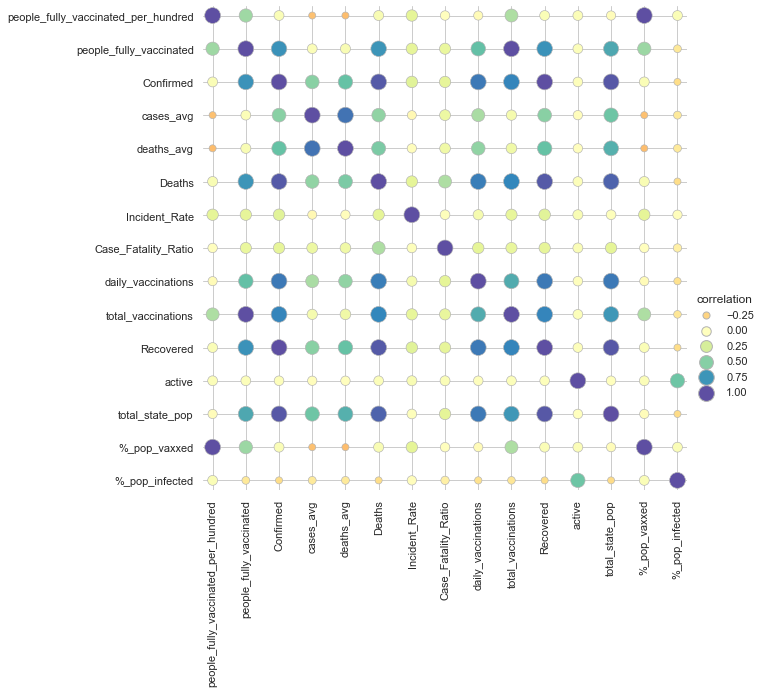

In [68]:
# Visualization of correlation matrix
corr_mat = tres.corr().stack().reset_index(name="correlation")

g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="Spectral", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

In [69]:
# reading travel change data
tch = pd.read_csv('TravelChangeData.csv')
# dropping military airports
tch = tch[~tch['Airport'].str.contains(r'NAF|AFS|AFB|AAF|MCAS')]
# dropping cols with no passenger info
tch = tch.drop(columns = ['Airport Country Name', 'Origin Airport Id', 'Origin State Abr', 'Freight tons', 'Latitude', 
                          'Longitude','Mail tons', 'Display City Market Name Full'])
# creating separate dataframes for each year's data
ptd = tch[tch['Year']== 2019].drop(columns = 'Year')
ptd = ptd.rename(columns={"Passengers": "Passengers 2019"})
ntd = tch[tch['Year'] == 2020].drop(columns = 'Year')
ntd = ntd.rename(columns={"Passengers": "Passengers 2020"})

#merging to compare years
ychd = pd.merge(ptd, ntd, on=['State' , 'Code', 'Airport', 'City'])
ychd = ychd.sort_values(by='State')
ychd.isnull().sum()

ychd['Passengers 2019'] = ychd['Passengers 2019'].interpolate(method='linear')
ychd['Passengers 2020'] = ychd['Passengers 2020'].interpolate(method='linear')

# summing values for each airport in each state
sych = ychd.drop(columns = ['Airport', 'City', 'Code'])
sych = sych.groupby(by='State').sum()
sych['Difference'] = sych['Passengers 2019'] - sych['Passengers 2020']
sych = sych.reset_index()
sych

State  Passengers 2019  Passengers 2020  \
0                          Alabama        2645096.0         797473.0   
1                           Alaska        3814742.5        1401341.0   
2                          Arizona       24850629.0        8880647.0   
3                         Arkansas        2040658.0         637534.0   
4                       California      104403549.0       28279957.0   
5                         Colorado       33755789.0       12214950.0   
6                      Connecticut        3278835.0         908505.0   
7                         Delaware            437.0             78.0   
8                          Florida       85959740.0       30538870.0   
9                          Georgia       54271290.0       15752656.0   
10                          Hawaii       16110388.0        4333627.0   
11                           Idaho        2425429.0         868243.0   
12                        Illinois       46171446.0       13420506.0   
13                         Indiana        5555549.0        1860345.5   
14                            Iowa        2118646.0         741278.0   
15                          Kansas         968468.0         329318.0   
16                        Kentucky        9013901.5        2061808.0   
17                       Louisiana        7942918.0        2405435.0   
18                           Maine        1214134.0         347771.0   
19                        Maryland       13082051.0        4094671.0   
20                   Massachusetts       17711322.0        4397725.0   
21                        Michigan       20625289.0        6200144.0   
22                       Minnesota       19385322.0        5640959.5   
23                     Mississippi        1002096.0         318189.0   
24                        Missouri       13925582.0        4224840.0   
25                         Montana        2263998.0         938195.0   
26                        Nebraska        2669494.0         849321.0   
27                          Nevada       24872772.0        8381565.0   
28                   New Hampshire         847852.0         248714.0   
29                      New Jersey       20679804.0        5696610.0   
30                      New Mexico        2814989.0         735724.0   
31                        New York       42722630.0        9969511.0   
32                  North Carolina       32944562.0       11790110.0   
33                    North Dakota         986208.0         404082.0   
34                            Ohio       10060121.0        3688137.5   
35                        Oklahoma        3664608.0        1190967.0   
36                          Oregon       11206903.0        3204619.0   
37                    Pennsylvania       20004583.0        5740444.0   
38                     Puerto Rico        4674777.0        1716566.0   
39                    Rhode Island        1882847.0         491553.0   
40                  South Carolina        5386225.0        1668476.0   
41                    South Dakota         874784.0         357259.0   
42                       Tennessee       12798927.0        4193256.0   
43                           Texas       88334423.0       30928690.0   
44  U.S. Pacific Trust Territories         753348.0         177815.0   
45             U.S. Virgin Islands         647282.0         299121.0   
46                            Utah       13079775.0        4609203.0   
47                         Vermont         596152.0         136766.0   
48                        Virginia       24429031.0        6390968.0   
49                      Washington       26889762.0        8182413.0   
50                   West Virginia         333125.0         115230.0   
51                       Wisconsin        5155467.0        1560382.0   
52                         Wyoming         615762.0         284906.0   

    Difference  
0    1847623.0  
1    2413401.5  
2   15969982.0  
3    1403124.0  
4   76123592.0  
5   21540839.0  
6    2370330.0  
7   

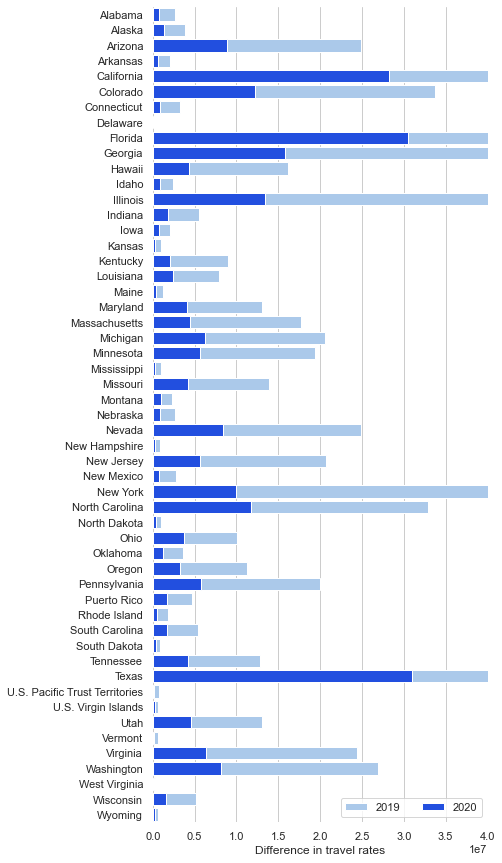

In [70]:
# Visualization of difference in number of travelers before and during the pandemic
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 15))


sns.set_color_codes("pastel")
sns.barplot(x="Passengers 2019", y="State", data=sych,
            label="2019", color="b")


sns.set_color_codes("bright")
sns.barplot(x="Passengers 2020", y="State", data=sych,
            label="2020", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 40000000), ylabel="",
       xlabel="Difference in travel rates")
sns.despine(left=True, bottom=True)



In [71]:
#gdf = geopandas.GeoDataFrame(
#    sych, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

In [72]:
# reading travel purpose data
tpd = pd.read_csv('TravelPurposeData.csv')
tpd = tpd[tpd['Year']== 2017].drop(columns=['Number of Records'])
tpd = tpd.drop(columns =['Year'])
tpd.drop(tpd.index[tpd['State'] == 'United States'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Other'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'School/Church'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Social/Recreational'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Work-related'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Work'], inplace = True)
tpd = tpd.drop(columns=['Trip Purpose', 'Number of Trips', 'Person miles (millions)', 'Person trips (millions)'])
tpd = tpd.rename(columns = {'Persons (thousands)': 'Travelers 2017'})
tpd['Travelers 2017'] = tpd['Travelers 2017'].astype('float64') * 1000
tpd.isnull().sum()
tpd

State  Travelers 2017
528               Alabama       4466000.0
534                Alaska        686000.0
540               Arizona       6382000.0
546              Arkansas       3084000.0
552            California      36632000.0
558              Colorado       4716000.0
564           Connecticut       2952000.0
570              Delaware        914000.0
576  District of Columbia       1241000.0
582               Florida      17719000.0
588               Georgia       9563000.0
594                Hawaii       1387000.0
600                 Idaho       1925000.0
606              Illinois      11984000.0
612               Indiana       5952000.0
618                  Iowa       3196000.0
624                Kansas       2564000.0
630              Kentucky       4445000.0
636             Louisiana       3829000.0
642                 Maine       1611000.0
648              Maryland       5650000.0
654         Massachusetts       6191000.0
660              Michigan       9260000.0
666             Minnesota       5815000.0
672           Mississippi       2820000.0
678              Missouri       4983000.0
684               Montana       1109000.0
690              Nebraska       1739000.0
696                Nevada       2240000.0
702         New Hampshire       1419000.0
708            New Jersey       8954000.0
714            New Mexico       1837000.0
720              New York      18683000.0
726        North Carolina       9449000.0
732          North Dakota        709000.0
738                  Ohio      11374000.0
744              Oklahoma       3802000.0
750                Oregon       4040000.0
756          Pennsylvania      11582000.0
762          Rhode Island       1045000.0
768        South Carolina       4610000.0
774          South Dakota        765000.0
780             Tennessee       6051000.0
786                 Texas      25468000.0
798                  Utah       3281000.0
804               Vermont        740000.0
810              Virginia       8344000.0
816            Washington       6447000.0
822         West Virginia       1967000.0
828             Wisconsin       5425000.0
834               Wyoming        553000.0

In [73]:
#merging both travel datasets together
#trav = pd.merge(sych, tpd, on = ['State'])
#trav

In [74]:
tres.info()
#tres['state'].head(55)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504 entries, 0 to 9503
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 9504 non-null   datetime64[ns]
 1   state                                9504 non-null   object        
 2   people_fully_vaccinated_per_hundred  9504 non-null   float64       
 3   people_fully_vaccinated              9504 non-null   float64       
 4   Confirmed                            9504 non-null   float64       
 5   cases_avg                            9504 non-null   float64       
 6   deaths_avg                           9504 non-null   float64       
 7   Deaths                               9504 non-null   float64       
 8   Incident_Rate                        9504 non-null   float64       
 9   Case_Fatality_Ratio                  9504 non-null   float64       
 10  daily_vaccin

[[ 0.07      ]
 [ 0.08      ]
 [ 0.408     ]
 [ 0.21      ]
 [ 0.4698773 ]
 [ 0.42018405]
 [ 0.3704908 ]
 [ 0.27      ]
 [ 0.33      ]
 [ 0.38      ]
 [ 0.56      ]
 [ 0.56      ]
 [ 0.56      ]
 [ 0.56      ]
 [ 0.61      ]
 [ 0.71      ]
 [ 0.84      ]
 [ 0.94      ]
 [ 1.03      ]
 [ 1.13      ]
 [ 1.18      ]
 [ 1.22      ]
 [ 1.33      ]
 [ 1.44      ]
 [ 1.59      ]
 [ 1.78      ]
 [ 1.98      ]
 [ 2.07      ]
 [ 2.15      ]
 [ 2.37      ]
 [ 2.63      ]
 [ 2.63      ]
 [ 2.96      ]
 [ 3.58      ]
 [ 4.36      ]
 [ 3.79      ]
 [ 3.79      ]
 [ 4.36      ]
 [ 4.97      ]
 [ 5.35      ]
 [ 5.74      ]
 [ 5.84      ]
 [ 5.88      ]
 [ 6.12      ]
 [ 6.36      ]
 [ 6.65      ]
 [ 6.98      ]
 [ 7.        ]
 [ 7.        ]
 [ 7.03      ]
 [ 7.3       ]
 [ 7.59      ]
 [ 7.93      ]
 [ 8.17      ]
 [ 8.42      ]
 [ 8.52      ]
 [ 8.58      ]
 [ 8.59      ]
 [ 8.82      ]
 [ 9.23      ]
 [ 9.5       ]
 [ 9.74      ]
 [ 9.84      ]
 [ 9.88      ]
 [ 9.89      ]
 [10.19      ]
 [10.21   

6/6 [==============================] - 0s 8ms/step - loss: 1.7314e-04
Epoch 69/100
6/6 [==============================] - 0s 7ms/step - loss: 1.8442e-04
Epoch 70/100
6/6 [==============================] - 0s 8ms/step - loss: 2.7440e-04
Epoch 71/100
6/6 [==============================] - 0s 8ms/step - loss: 2.1288e-04
Epoch 72/100
6/6 [==============================] - 0s 7ms/step - loss: 1.1608e-04
Epoch 73/100
6/6 [==============================] - 0s 8ms/step - loss: 1.1543e-04
Epoch 74/100
6/6 [==============================] - 0s 8ms/step - loss: 1.5947e-04
Epoch 75/100
6/6 [==============================] - 0s 7ms/step - loss: 1.1084e-04
Epoch 76/100
6/6 [==============================] - 0s 7ms/step - loss: 9.8557e-05
Epoch 77/100
6/6 [==============================] - 0s 7ms/step - loss: 8.5474e-05
Epoch 78/100
6/6 [==============================] - 0s 7ms/step - loss: 9.3952e-05
Epoch 79/100
6/6 [==============================] - 0s 7ms/step - loss: 1.0590e-04
Epoch 80/100
6/6 

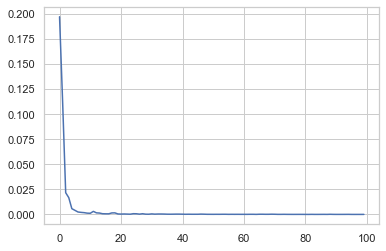

In [75]:
oneT = tres.loc[tres['state'] == 'Georgia']
oneT
v_data = oneT['%_pop_vaxxed'].values
v_data = v_data.reshape((-1,1))
print(v_data)
scaler = MinMaxScaler()
scaler.fit(v_data)
v_data = scaler.fit_transform(v_data)

split_per = 0.80
splitt = int(split_per*len(v_data))

v_train = v_data[:splitt]
v_test = v_data[splitt::]

d_train = oneT['date'][:splitt]
d_test = oneT['date'][splitt:]

look_bak = 35

train_gen = TimeseriesGenerator(v_train, v_train, length=look_bak, batch_size=20)     
test_gen = TimeseriesGenerator(v_test, v_test, length=look_bak, batch_size=1)

mod = Sequential()
mod.add(LSTM(100, activation='relu', input_shape=(look_bak,1)))
mod.add(Dense(10, activation='relu'))
mod.add(Dense(1))
mod.compile(optimizer='adam', loss='mse')


num_epochs = 100

mod.fit(train_gen, epochs=num_epochs, verbose=1)

loss_per_epoch = mod.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)



In [81]:
prediction = mod.predict_generator(test_gen)

v_train = v_train.reshape((-1))
v_test = v_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = d_train,
    y = v_train*100,
    mode = 'lines',
    name = 'Training Data'
)
trace2 = go.Scatter(
    x = d_test,
    y = prediction*100,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = d_test,
    y = v_test*100,
    mode='lines',
    name = 'Actual'
)
layout = go.Layout(
    title = "Predicted Vaccinations",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Percent Vaccinated"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

Instructions for updating:
Please use Model.predict, which supports generators.


In [84]:
v_data = v_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = v_data[-look_bak:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_bak:]
        x = x.reshape((1, look_bak, 1))
        out = mod.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_bak-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = oneT['date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecastt = predict(num_prediction, mod)
forecastt_dates = predict_dates(num_prediction)
print(forecastt)
print(forecastt_dates)

[1.         0.97922099 0.97978783 0.98030442 0.9807722  0.98120534
 0.98160189 0.98196983 0.98230624 0.98263448 0.98295164 0.98326343
 0.98356438 0.98386842 0.98416525 0.98446554 0.98477054 0.98506188
 0.98533797 0.98560774 0.9858712  0.98612887 0.98637921 0.98662353
 0.98686236 0.98709625 0.98732483 0.9875477  0.98776245 0.98796517
 0.98816323]
[Timestamp('2021-07-06 00:00:00', freq='D'), Timestamp('2021-07-07 00:00:00', freq='D'), Timestamp('2021-07-08 00:00:00', freq='D'), Timestamp('2021-07-09 00:00:00', freq='D'), Timestamp('2021-07-10 00:00:00', freq='D'), Timestamp('2021-07-11 00:00:00', freq='D'), Timestamp('2021-07-12 00:00:00', freq='D'), Timestamp('2021-07-13 00:00:00', freq='D'), Timestamp('2021-07-14 00:00:00', freq='D'), Timestamp('2021-07-15 00:00:00', freq='D'), Timestamp('2021-07-16 00:00:00', freq='D'), Timestamp('2021-07-17 00:00:00', freq='D'), Timestamp('2021-07-18 00:00:00', freq='D'), Timestamp('2021-07-19 00:00:00', freq='D'), Timestamp('2021-07-20 00:00:00', fr

In [86]:
prediction = mod.predict_generator(test_gen)

v_train = v_train.reshape((-1))
v_test = v_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = d_train,
    y = v_train*100,
    mode = 'lines',
    name = 'Training Data'
)
trace2 = go.Scatter(
    x = forecastt_dates,
    y = forecastt*100,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = d_test,
    y = v_test*100,
    mode='lines',
    name = 'Actual'
)
layout = go.Layout(
    title = "Predicted Vaccinations",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Percent Vaccinated"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [87]:
preT = pd.DataFrame()
preT['date'] = forecastt_dates
preT['state'] =oneT['state']
preT.set_index(['state','date'], inplace=True)
forecastt = scaler.inverse_transform(forecastt.reshape((-1,1)))
preT['Predicted_vaxxed'] = forecastt

preT

Predicted_vaxxed
state   date                        
NaN     2021-07-06         36.980000
        2021-07-07         36.213047
        2021-07-08         36.233969
        2021-07-09         36.253036
        2021-07-10         36.270302
        2021-07-11         36.286289
        2021-07-12         36.300926
        2021-07-13         36.314507
        2021-07-14         36.326923
        2021-07-15         36.339039
Georgia 2021-07-16         36.350745
NaN     2021-07-17         36.362253
        2021-07-18         36.373361
        2021-07-19         36.384583
        2021-07-20         36.395539
        2021-07-21         36.406623
        2021-07-22         36.417880
        2021-07-23         36.428634
        2021-07-24         36.438825
        2021-07-25         36.448782
        2021-07-26         36.458506
        2021-07-27         36.468016
        2021-07-28         36.477257
        2021-07-29         36.486274
        2021-07-30         36.495090
        2021-07-31         36.503723
        2021-08-01         36.512160
        2021-08-02         36.520385
        2021-08-03         36.528312
        2021-08-04         36.535794
        2021-08-05         36.543105

In [88]:
df_train = tres.copy()
#df_train = df_train.set_axis(df_train['date'])
df_train.state = df_train.state.map({'Alabama':0.0, 'Alaska':1.0, 'Arizona':2.0, 'Arkansas':3.0, 'California':4.0,
                                   'Colorado':5.0, 'Connecticut':6.0, 'Delaware':7.0, 'District of Columbia':8.0,
                                   'Florida':9.0, 'Georgia':10.0, 'Guam':11.0, 'Hawaii':12.0, 'Idaho':13.0, 'Illinois':14.0,
                                    'Indiana':15.0, 'Iowa':16.0, 'Kansas':17.0, 'Kentucky':18.0, 'Louisiana':19.0, 
                                    'Maine':20.0, 'Maryland':21.0, 'Massachusetts':22.0, 'Michigan':23.0, 'Minnesota':24.0,
                                    'Mississippi':25.0, 'Missouri':26.0, 'Montana':27.0, 'Nebraska':28.0, 'Nevada':29.0,
                                    'New Hampshire':30.0, 'New Jersey':31.0, 'New Mexico':32.0, 'North Carolina':33.0, 
                                    'North Dakota':34.0, 'New York':35.0,'Northern Mariana Islands':36.0, 'Ohio':37.0, 'Oklahoma':38.0,
                                    'Oregon':39.0, 'Pennsylvania':40.0, 'Puerto Rico':41.0, 'Rhode Island':42.0, 
                                    'South Carolina':43.0, 'South Dakota':44.0, 'Tennessee':45.0, 'Texas':46.0, 'Utah':47.0,
                                    'Vermont':48.0, 'Virginia':49.0, 'Washington':50.0, 'West Virginia':51.0, 'Wisconsin':52.0,
                                    'Wyoming':53.0})

date_values = df_train['date'].values
state_data = df_train['state'].values
y_data = df_train['%_pop_vaxxed'].values
x_data = df_train.drop(['deaths_avg', 'Deaths', 'Case_Fatality_Ratio','total_vaccinations',
                       '%_pop_infected', 'Recovered', 'cases_avg', 'Confirmed',
                       'Incident_Rate', 'active', 'people_fully_vaccinated', 'daily_vaccinations', 'total_state_pop'], axis=1)

In [89]:
#x_data = x_data.loc[1.0]
x_data

date  state  people_fully_vaccinated_per_hundred  %_pop_vaxxed
0    2021-01-12    0.0                                 0.15          0.15
1    2021-01-12    1.0                                 0.74          0.74
2    2021-01-12    2.0                                 0.11          0.11
3    2021-01-12    3.0                                 0.00          0.00
4    2021-01-12    4.0                                 0.25          0.25
...         ...    ...                                  ...           ...
9499 2021-07-06   49.0                                52.47         52.47
9500 2021-07-06   50.0                                55.24         55.24
9501 2021-07-06   51.0                                37.47         37.47
9502 2021-07-06   52.0                                50.34         50.34
9503 2021-07-06   53.0                                35.36         35.36

[9504 rows x 4 columns]

In [91]:
#date_values = (date_values-date_values.min())/(date_values.max()-date_values.min())
#date_values

In [92]:
#x_data['date'] = date_values
x_data = x_data.drop(['date'], axis=1)
#x_data.stack
#x_data.reset_index()
x_data.set_index('state', inplace=True)
x_data

people_fully_vaccinated_per_hundred  %_pop_vaxxed
state                                                   
0.0                                   0.15          0.15
1.0                                   0.74          0.74
2.0                                   0.11          0.11
3.0                                   0.00          0.00
4.0                                   0.25          0.25
...                                    ...           ...
49.0                                 52.47         52.47
50.0                                 55.24         55.24
51.0                                 37.47         37.47
52.0                                 50.34         50.34
53.0                                 35.36         35.36

[9504 rows x 2 columns]

In [93]:
split_rate = 0.80
split = int(split_rate*len(x_data))

vax_data = x_data.values
vax_data = vax_data.reshape((-1,1))

scaler = MinMaxScaler()
scaler.fit(vax_data)
vax_data = scaler.fit_transform(vax_data)


X_train = vax_data[:split]
X_test = vax_data[split:]

dates = df_train['date'].values

date_train = df_train['date'][:split]
date_test = df_train['date'][split:]

#X_train.shape #(7462, 5)
#X_test.shape () #(1866,)

In [94]:
look_back = 60

train_generator = TimeseriesGenerator(X_train, X_train, length=look_back, batch_size=15)
test_generator = TimeseriesGenerator(X_test, X_test, length=look_back, batch_size=1)

In [95]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(10, activation ='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

In [96]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 41,821
Trainable params: 41,821
Non-trainable params: 0
_________________________________________________________________


In [98]:
model.fit(train_generator, epochs=10, verbose=1)

Epoch 1/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0101
Epoch 2/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0099
Epoch 3/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0100
Epoch 4/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0101
Epoch 5/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0099
Epoch 6/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0098
Epoch 7/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0099
Epoch 8/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0097
Epoch 9/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0098
Epoch 10/10
503/503 [==============================] - 7s 14ms/step - loss: 0.0101


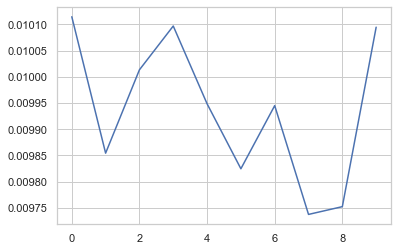

In [99]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [100]:
pred = model.predict(test_generator)

X_train = X_train.reshape((-1))
X_test = X_test.reshape((-1))
pred = pred.reshape((-1))

dd = go.Scatter(
    x = date_train,
    y = X_train,
    mode = 'lines',
    name = 'Train data'
)
dd2 = go.Scatter(
    x = date_test,
    y = pred,
    mode = 'lines',
    name = 'Predicted'
)
dd3 = go.Scatter(
    x = date_test,
    y = X_test,
    mode='lines',
    name = 'True'
)

layout = go.Layout(
    title = "Predicted vaccinations",
    xaxis = {'title' : 'Date'},
    yaxis = {'title' : "Vaccinations"}
)

fig = go.Figure(data=[dd, dd2, dd3], layout=layout)
fig.show()

In [101]:
vax_data = vax_data.reshape((-1))
vax_data.shape

(19008,)

In [102]:
#vax_data = vax_data.reshape((-1))

def predict(num_prediction, model):
    predicted_list = vax_data[-look_back:]
    
    for _ in range(num_prediction):
        x = predicted_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        output = model.predict(x)[0][0]
        predicted_list = np.append(predicted_list, output)
    predicted_list = predicted_list[look_back-1:]
    
    return predicted_list

def pred_dates(num_prediction):
    last_date = df_train['date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction =90
forecast = predict(num_prediction, model)
forecast_dates = pred_dates(num_prediction)

print(forecast)
print("\n")
print(forecast_dates)

[0.53494705 0.52417856 0.5214873  0.50942481 0.49890009 0.48851362
 0.47763205 0.46701655 0.45680204 0.44699943 0.43759137 0.42852429
 0.41979593 0.4113988  0.4033232  0.39555833 0.38808855 0.38090691
 0.37399822 0.36734858 0.36094728 0.35478112 0.34884003 0.34311295
 0.33758724 0.33225849 0.32711551 0.32214829 0.31735054 0.31271255
 0.30822891 0.30389145 0.29969457 0.2956312  0.29170468 0.28790209
 0.28421661 0.28064248 0.27717501 0.27380908 0.27054068 0.26736549
 0.26427966 0.26128003 0.25836322 0.25552592 0.25276527 0.25007841
 0.24746267 0.24491553 0.24243458 0.2400174  0.23771892 0.235478
 0.23328505 0.23114526 0.22905867 0.22702387 0.22503915 0.22310278
 0.2212134  0.2193701  0.21757135 0.21581472 0.21409923 0.21242376
 0.21078716 0.20913126 0.20746429 0.20580655 0.20416664 0.2025464
 0.20094573 0.19936565 0.19780095 0.19624458 0.19469704 0.19315864
 0.19162972 0.19011031 0.18860063 0.18710057 0.1856101  0.18412913
 0.18265751 0.18119511 0.17974167 0.1782971  0.17686118 0.1754336

In [104]:
pre = pd.DataFrame()
pre['date'] = forecast_dates
pre['state'] =xdf['state']
pre.set_index(['state','date'], inplace=True)
forecast = scaler.inverse_transform(forecast.reshape((-1,1)))
pre['Predicted_vaxxed'] = forecast

pre.stack()
pre

Predicted_vaxxed
state          date                        
Alabama        2021-07-06       2337.296000
Alaska         2021-07-07       2290.246226
American Samoa 2021-07-08       2278.487507
Arizona        2021-07-09       2225.783955
Arkansas       2021-07-10       2179.799243
...                                     ...
Nevada         2021-09-30        785.329083
New Hampshire  2021-10-01        779.017483
New Jersey     2021-10-02        772.743644
New Mexico     2021-10-03        766.506526
New York       2021-10-04        760.306127

[91 rows x 1 columns]

In [289]:
v_df = df_train.copy()

In [290]:
v_df

date  state  people_fully_vaccinated_per_hundred  \
0    2021-01-12    0.0                                 0.15   
1    2021-01-12    1.0                                 0.74   
2    2021-01-12    2.0                                 0.11   
3    2021-01-12    3.0                                 0.00   
4    2021-01-12    4.0                                 0.25   
...         ...    ...                                  ...   
9499 2021-07-06   49.0                                52.47   
9500 2021-07-06   50.0                                55.24   
9501 2021-07-06   51.0                                37.47   
9502 2021-07-06   52.0                                50.34   
9503 2021-07-06   53.0                                35.36   

      people_fully_vaccinated  Confirmed  cases_avg  deaths_avg   Deaths  \
0                      7270.0   404000.0    4036.43       76.83   5347.0   
1                      5400.0    50413.0     277.29        1.00    224.0   
2                      8343.0   627541.0    9580.43      169.00  10147.0   
3                         8.0   256344.0    2952.14       40.71   4081.0   
4                    100089.0  2784716.0   43491.86      517.00  30519.0   
...                       ...        ...        ...         ...      ...   
9499                4478317.0   681194.0     180.14        3.14  11431.0   
9500                4206349.0   452483.0     331.86        6.86   5939.0   
9501                 671593.0   164149.0      41.00        1.67   2899.0   
9502                2930845.0   678008.0      73.86        2.57   8144.0   
9503                 204636.0    62445.0      63.86        0.57    747.0   

      Incident_Rate  Case_Fatality_Ratio  daily_vaccinations  \
0           8239.54                 1.32             13415.0   
1           6888.71                 0.44             13415.0   
2           8621.59                 1.62             13415.0   
3           8494.39                 1.59             13415.0   
4           6980.17                 1.11             13415.0   
...             ...                  ...                 ...   
9499        7980.70                 1.68             16147.0   
9500        5942.08                 1.31             19116.0   
9501        9159.35                 1.77              1529.0   
9502       11644.75                 1.20             11972.0   
9503       10789.47                 1.20              1350.0   

      total_vaccinations  Recovered    active  total_state_pop  %_pop_vaxxed  \
0                78134.0   398653.0    9853.0        4903185.0          0.15   
1                35838.0    50189.0   70545.0         731545.0          0.74   
2               141355.0   617394.0   50278.0        7278717.0          0.11   
3                40879.0   252263.0    2166.0        3017804.0          0.00   
4               816301.0  2754197.0    3261.0       39512223.0          0.25   
...                  ...        ...       ...              ...           ...   
9499           9328521.0   669763.0    7538.0        8535519.0         52.47   
9500           8676836.0   446544.0  153590.0        7614893.0         55.24   
9501           1426490.0   161250.0  403149.0        1792147.0         37.47   
9502           5982183.0   669864.0   98617.0        5822434.0         50.34   
9503            431146.0    61698.0   31759.0         578759.0         35.36   

      %_pop_infected  
0               0.20  
1               9.64  
2               0.69  
3               0.07  
4               0.01  
...              ...  
9499            0.09  
9500            2.02  
9501           22.50  
9502            1.69  
9503            5.49  

[9504 rows x 17 columns]

In [291]:
v_df = v_df.set_index(['date', 'state'])
v_df

people_fully_vaccinated_per_hundred  \
date       state                                        
2021-01-12 0.0                                   0.15   
           1.0                                   0.74   
           2.0                                   0.11   
           3.0                                   0.00   
           4.0                                   0.25   
...                                               ...   
2021-07-06 49.0                                 52.47   
           50.0                                 55.24   
           51.0                                 37.47   
           52.0                                 50.34   
           53.0                                 35.36   

                  people_fully_vaccinated  Confirmed  cases_avg  deaths_avg  \
date       state                                                              
2021-01-12 0.0                     7270.0   404000.0    4036.43       76.83   
           1.0                     5400.0    50413.0     277.29        1.00   
           2.0                     8343.0   627541.0    9580.43      169.00   
           3.0                        8.0   256344.0    2952.14       40.71   
           4.0                   100089.0  2784716.0   43491.86      517.00   
...                                   ...        ...        ...         ...   
2021-07-06 49.0                 4478317.0   681194.0     180.14        3.14   
           50.0                 4206349.0   452483.0     331.86        6.86   
           51.0                  671593.0   164149.0      41.00        1.67   
           52.0                 2930845.0   678008.0      73.86        2.57   
           53.0                  204636.0    62445.0      63.86        0.57   

                   Deaths  Incident_Rate  Case_Fatality_Ratio  \
date       state                                                
2021-01-12 0.0     5347.0        8239.54                 1.32   
           1.0      224.0        6888.71                 0.44   
           2.0    10147.0        8621.59                 1.62   
           3.0     4081.0        8494.39                 1.59   
           4.0    30519.0        6980.17                 1.11   
...                   ...            ...                  ...   
2021-07-06 49.0   11431.0        7980.70                 1.68   
           50.0    5939.0        5942.08                 1.31   
           51.0    2899.0        9159.35                 1.77   
           52.0    8144.0       11644.75                 1.20   
           53.0     747.0       10789.47                 1.20   

                  daily_vaccinations  total_vaccinations  Recovered    active  \
date       state                                                                
2021-01-12 0.0               13415.0             78134.0   398653.0    9853.0   
           1.0               13415.0             35838.0    50189.0   70545.0   
           2.0               13415.0            141355.0   617394.0   50278.0   
           3.0               13415.0             40879.0   252263.0    2166.0   
           4.0               13415.0            816301.0  2754197.0    3261.0   
...                              ...                 ...        ...       ...   
2021-07-06 49.0              16147.0           9328521.0   669763.0    7538.0   
           50.0              19116.0           8676836.0   446544.0  153590.0   
           51.0               1529.0           1426490.0   161250.0  403149.0   
           52.0              11972.0           5982183.0   669864.0   98617.0   
           53.0               1350.0            431146.0    61698.0   31759.0   

                  total_state_pop  %_pop_vaxxed  %_pop_infected  
date       state                                                 
2021-01-12 0.0          4903185.0          0.15            0.20  
           1.0           731545.0          0.74            9.64  
           2.0          7278717.0          0.11            0.69  
           3.0    

In [292]:
v_df = v_df.drop(['people_fully_vaccinated_per_hundred', 'Confirmed', 'cases_avg', 'deaths_avg', 'Deaths',
                 'Incident_Rate', 'Case_Fatality_Ratio', 'Recovered', 'active', '%_pop_infected'], axis=1)

In [293]:
v_df

people_fully_vaccinated  daily_vaccinations  \
date       state                                                
2021-01-12 0.0                     7270.0             13415.0   
           1.0                     5400.0             13415.0   
           2.0                     8343.0             13415.0   
           3.0                        8.0             13415.0   
           4.0                   100089.0             13415.0   
...                                   ...                 ...   
2021-07-06 49.0                 4478317.0             16147.0   
           50.0                 4206349.0             19116.0   
           51.0                  671593.0              1529.0   
           52.0                 2930845.0             11972.0   
           53.0                  204636.0              1350.0   

                  total_vaccinations  total_state_pop  %_pop_vaxxed  
date       state                                                     
2021-01-12 0.0               78134.0        4903185.0          0.15  
           1.0               35838.0         731545.0          0.74  
           2.0              141355.0        7278717.0          0.11  
           3.0               40879.0        3017804.0          0.00  
           4.0              816301.0       39512223.0          0.25  
...                              ...              ...           ...  
2021-07-06 49.0            9328521.0        8535519.0         52.47  
           50.0            8676836.0        7614893.0         55.24  
           51.0            1426490.0        1792147.0         37.47  
           52.0            5982183.0        5822434.0         50.34  
           53.0             431146.0         578759.0         35.36  

[9504 rows x 5 columns]

In [294]:
scaley = StandardScaler()
scaley = scaley.fit(v_df)
vdf_sc = scaley.transform(v_df)

In [295]:
trainX = []
trainY = []

In [296]:
n_future = 30
n_past = 90

In [297]:
for i in range (n_past, len(vdf_sc) - n_future+1):
    trainX.append(vdf_sc[i - n_past:i, 0:v_df.shape[1]])
    trainY.append(vdf_sc[i +n_future - 1:i + n_future, 0])
    
trainX, trainY = np.array(trainX), np.array(trainY)

In [298]:
print('trainX shape == {}'.format(trainX.shape))
print('trainY shape == {}'.format(trainY.shape))

trainX shape == (9385, 90, 5)
trainY shape == (9385, 1)


In [299]:
model1 = Sequential()
model1.add(LSTM(100, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model1.add(LSTM(50, activation='relu', return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(trainY.shape[1]))

model1.compile(optimizer='adam', loss='mse')
model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 90, 100)           42400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 72,651
Trainable params: 72,651
Non-trainable params: 0
_________________________________________________________________


In [300]:
hist = model1.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
264/264 [==============================] - 13s 49ms/step - loss: 0.6738 - val_loss: 2.2670
Epoch 2/10
264/264 [==============================] - 13s 48ms/step - loss: 0.6429 - val_loss: 2.1378
Epoch 3/10
264/264 [==============================] - 13s 48ms/step - loss: 0.5948 - val_loss: 1.9840
Epoch 4/10
264/264 [==============================] - 13s 48ms/step - loss: 0.4584 - val_loss: 1.3486
Epoch 5/10
264/264 [==============================] - 13s 48ms/step - loss: 0.2939 - val_loss: 0.7173
Epoch 6/10
264/264 [==============================] - 13s 47ms/step - loss: 0.1745 - val_loss: 0.6404
Epoch 7/10
264/264 [==============================] - 13s 49ms/step - loss: 0.1337 - val_loss: 0.4493
Epoch 8/10
264/264 [==============================] - 14s 53ms/step - loss: 0.0869 - val_loss: 0.4290
Epoch 9/10
264/264 [==============================] - 13s 50ms/step - loss: 0.0895 - val_loss: 0.3310
Epoch 10/10
264/264 [==============================] - 13s 48ms/step - loss: 0.087

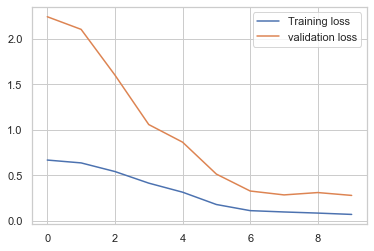

In [262]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend()

In [263]:
n_future = 120
forecast_period_dates = pd.date_range(list(date_values)[-1], periods=n_future, freq='1d').tolist()

In [264]:
big_forecast = model1.predict(trainX[-n_future:])

In [272]:
copied_forecast = np.repeat(big_forecast, vdf_sc.shape[1], axis=-1)
y_pred_future = scaley.inverse_transform(copied_forecast)[:,4]
#y_pred_state_future = scaley.inverse_transform(copied_forecast)[:,2]

In [273]:
forecast_days = []
for time_i in forecast_period_dates:
    forecast_days.append(time_i.date())

In [339]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_days),'%_vaxxed':y_pred_future})
df_forecast['Date'] = df_forecast['Date'].astype('datetime64[ns]')

df_forecast = df_forecast.set_index(['Date'])
#df_forecast['State'] = df_forecast['State'].round(0)
df_forecast

%_vaxxed
Date                  
2021-07-06   17.473749
2021-07-07   24.263124
2021-07-08   15.302934
2021-07-09   27.109121
2021-07-10  100.773682
...                ...
2021-10-29   43.906727
2021-10-30   39.471832
2021-10-31   19.477390
2021-11-01   24.092651
2021-11-02   22.235460

[120 rows x 1 columns]

In [140]:
#scaler = MinMaxScaler()

In [17]:
'''
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)
'''

'\nscaler.fit(X_train)\nscaled_train = scaler.transform(X_train)\nscaled_test = scaler.transform(X_test)\n'

In [18]:
'''
num_input = 14
num_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=num_input, batch_size=1)
'''

'\nnum_input = 14\nnum_features = 1\ngenerator = TimeseriesGenerator(scaled_train, scaled_train, length=num_input, batch_size=1)\n'

In [19]:
'''
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(num_input, num_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
'''

"\nmodel = Sequential()\nmodel.add(LSTM(100, activation='relu', input_shape=(num_input, num_features)))\nmodel.add(Dense(1))\nmodel.compile(optimizer='adam', loss='mse')\n"

In [20]:
#model.summary()

In [21]:
#model.fit(generator, epochs=10)

In [22]:
#loss_per_epoch = model.history.history['loss']
#plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [23]:
#last_train_batch = scaled_train[-14:]

In [24]:
#last_train_batch = last_train_batch.reshape((1, num_input, num_features))

In [25]:
#model.predict(last_train_batch)

In [26]:
#scaled_test[0]

In [27]:
'''
test_predictions = []

first_eval_batch = scaled_train[-num_input:]
current_batch = first_eval_batch.reshape(1, num_input, num_features)

for i in range(len(X_test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
'''

'\ntest_predictions = []\n\nfirst_eval_batch = scaled_train[-num_input:]\ncurrent_batch = first_eval_batch.reshape(1, num_input, num_features)\n\nfor i in range(len(X_test)):\n    \n    current_pred = model.predict(current_batch)[0]\n    \n    test_predictions.append(current_pred)\n    \n    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)\n'

In [28]:
#test_predictions

In [29]:
#X_test

In [30]:
#tru_pred = scaler.inverse_transform(test_predictions)

In [31]:
#X_test['Predicted_Vaxxed'] = tru_pred

In [32]:
#X_test.plot(figsize=(10, 5))

In [33]:
'''
y_true = X_test['%_pop_vaxxed'].values
y_pred = tru_pred

model_acc = r2_score(y_true, y_pred)
model_acc = np.round(model_acc, 2)
print("R2 Score(rough estimate model accuracy): ")
print(model_acc)
rmse=sqrt(mean_squared_error(X_test['%_pop_vaxxed'],X_test['Predicted_Vaxxed']))
print("Root_Mean_Squared_error: ")
print(round(rmse, 2))
'''

'\ny_true = X_test[\'%_pop_vaxxed\'].values\ny_pred = tru_pred\n\nmodel_acc = r2_score(y_true, y_pred)\nmodel_acc = np.round(model_acc, 2)\nprint("R2 Score(rough estimate model accuracy): ")\nprint(model_acc)\nrmse=sqrt(mean_squared_error(X_test[\'%_pop_vaxxed\'],X_test[\'Predicted_Vaxxed\']))\nprint("Root_Mean_Squared_error: ")\nprint(round(rmse, 2))\n'